In [139]:
# Install necessary library
!pip install segmentation_models --quiet
!pip install -U tensorflow keras segmentation-models --quiet

In [140]:
# List existing image files (zipped)
!ls

cpu  landcoverai  landcoverai-20250306T133829Z-001.zip	models


In [141]:
pwd

'/project'

In [142]:
# Necessary because of a bug https://github.com/qubvel/segmentation_models/issues/374
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [143]:
!pip install matplotlib scikit-learn --quiet

In [144]:
import os
import random
from pathlib import Path

import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import segmentation_models as sm
from keras.models import load_model
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [145]:
# In case the model gets very slow, may be due to a bug in TF2.0. Uncomment this.
# https://github.com/tensorflow/tensorflow/issues/33024
# tf.compat.v1.disable_eager_execution()

# Also check this in case you notice training to be getting increasingly slow each epoch.
# https://stackoverflow.com/questions/53683164/keras-occupies-an-indefinitely-increasing-amount-of-memory-for-each-epoch

In [146]:
# Define needed directory paths
dir_root = Path("/project/landcoverai/")
dir_train_img = Path(dir_root, "train_images/train/")
dir_train_mask = Path(dir_root, "train_masks/train/")
dir_val_img = Path(dir_root, "val_images/val/")
dir_val_mask = Path(dir_root, "val_masks/val/")
dir_models = Path("/project/models/")




# Show how many image files exist
for dir in [dir_train_img, dir_train_mask, dir_val_img, dir_val_mask]:
    files = patch_files = [file for file in dir.iterdir()]
    print(f"{dir} has {len(files)} images.")

/project/landcoverai/train_images/train has 2250 images.
/project/landcoverai/train_masks/train has 2250 images.
/project/landcoverai/val_images/val has 750 images.
/project/landcoverai/val_masks/val has 750 images.


In [147]:
classes = {
    0: "Not classified",
    1: "Building",
    2: "Woodland",
    3: "Water",
    4: "Roads",
}

### Visualize random patch alongside its mask

In [148]:
def plot_image_and_mask(image: Path):
    """
    Function to plot an image alongside its mask.
    """
    img = cv2.imread(image.as_posix())
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask_path = Path(image.as_posix().replace("/train_images/", "/train_masks/"))
    mask = cv2.imread(mask_path.as_posix())

    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

    ax1.imshow(img)
    ax1.set_title("Channel 0")

    norm = mpl.colors.Normalize(vmin=0, vmax=4)
    cmap = plt.get_cmap("viridis")

    ax2.imshow(mask[:, :, 1], cmap=cmap, norm=norm)
    ax2.set_title("Mask")

    plt.show()


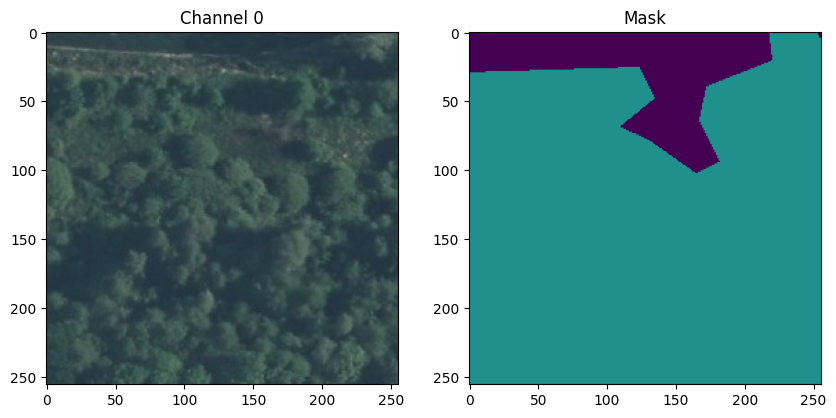

In [149]:
# Get paths of all images
img_files = [file for file in dir_train_img.iterdir()]

# Get random image from all images
img_path = np.random.choice(img_files)

plot_image_and_mask(img_path)


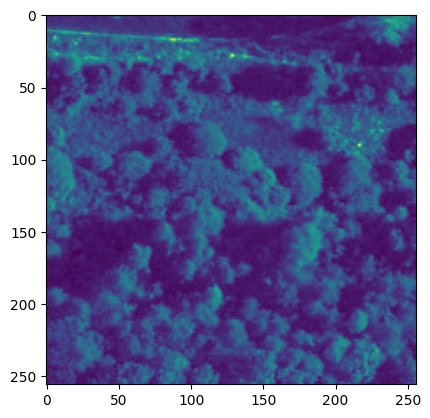

In [150]:
#Quick understanding of the dataset
temp_img = cv2.imread(img_path) #3 channels / spectral bands
plt.imshow(temp_img[:,:,0]) #View each channel...
plt.imshow(temp_img[:,:,1]) #View each channel...
plt.imshow(temp_img[:,:,2]) #View each channel...
temp_mask = cv2.imread(img_path) #3 channels but all same.






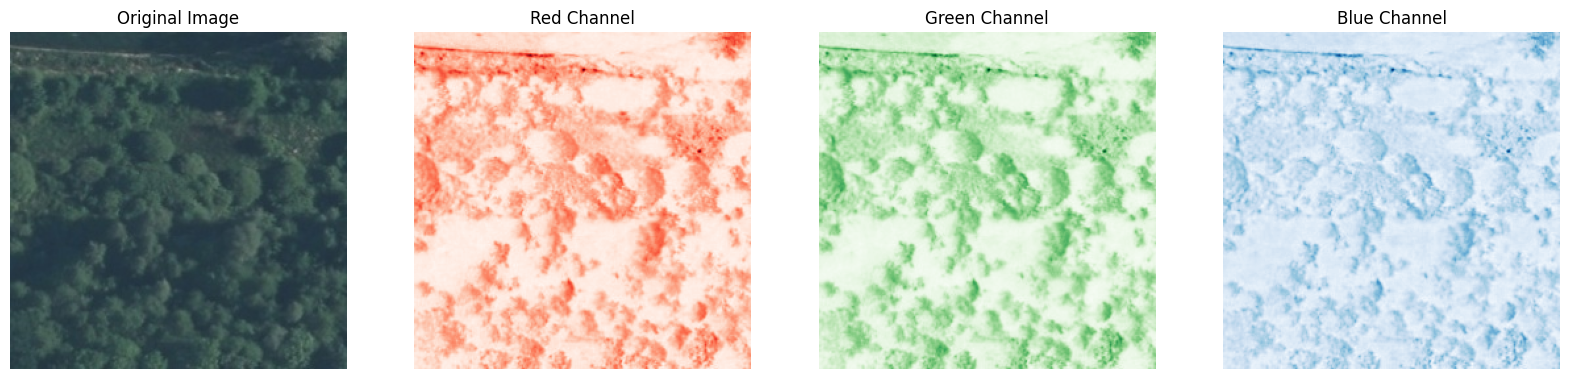

In [151]:


import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread(img_path)  # Reads in BGR format
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Split the channels
red_channel = img[:, :, 0]  # Red channel
green_channel = img[:, :, 1]  # Green channel
blue_channel = img[:, :, 2]  # Blue channel

# Plot the channels
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].imshow(img)  # Original image
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(red_channel, cmap="Reds")
axs[1].set_title("Red Channel")
axs[1].axis("off")

axs[2].imshow(green_channel, cmap="Greens")
axs[2].set_title("Green Channel")
axs[2].axis("off")

axs[3].imshow(blue_channel, cmap="Blues")
axs[3].set_title("Blue Channel")
axs[3].axis("off")

plt.show()

In [152]:
labels, count = np.unique(temp_mask[:,:,0], return_counts=True) #Check for each channel. All chanels are identical
print("Labels are: ", labels, " and the counts are: ", count)

Labels are:  [ 56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 129 130 134 136 142 143 145 148 149 150 153]  and the counts are:  [   3    5    4   26   58  130  270  551 1120 1852 2592 3266 3677 3773
 3601 3148 2940 2713 2518 2500 2336 2309 2107 2041 1994 1901 1846 1731
 1493 1468 1405 1287 1153 1028  961  897  754  619  618  492  411  318
  285  224  206  149  142  140   77   85   60   39   35   23   30   12
   18   16    8   14    5    8    4    4    5    3    2    3    2    4
    1    3    3    1    1    1    1    1    1    1    1    1    1]


In [153]:
import numpy as np

# Example: Assume temp_mask[:,:,0] contains many unique labels
labels, count = np.unique(temp_mask[:, :, 0], return_counts=True)
print("Original Labels:", labels)

# Create a mapping dictionary to reassign labels to [0,1,2,3,...]
# Ensure all labels in temp_mask are included in the mapping
label_mapping = {old_label: new_label for new_label, old_label in enumerate(labels)} #Changed labels[:4] to labels

# Apply mapping to mask
remapped_mask = np.vectorize(label_mapping.get)(temp_mask[:, :, 0])

# Print new unique labels
new_labels, new_count = np.unique(remapped_mask, return_counts=True)
print("New Labels:", new_labels)
print("New Counts:", new_count)

Original Labels: [ 56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 129 130 134 136 142 143 145 148 149 150 153]
New Labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82]
New Counts: [   3    5    4   26   58  130  270  551 1120 1852 2592 3266 3677 3773
 3601 3148 2940 2713 2518 2500 2336 2309 2107 2041 1994 1901 1846 1731
 1493 1468 1405 1287 1153 1028  961  897  754  619  618  492  411  318
  285  224  206  149  142  140   77   85   60   39   35   23   30   12
   18   16    8   14    5    8    4    4    5    3    2    3    2    4
    1    3  

### Define Generator for images and masks

In [154]:

import segmentation_models as sm

seed = 24
batch_size = 16  # Lower to 8 in case of memory issues
n_classes = len(classes)
encoder_freeze = True

# Use this to preprocess input for transfer learning
BACKBONE = "resnet152"
preprocess_input = sm.get_preprocessing(BACKBONE) # Now sm is defined and this line should work.

In [155]:
print(n_classes)

5


In [156]:
def preprocess_data(img, mask, num_class):
    """
    Function to perform additional preprocessing after datagen.
    """
    scaler = MinMaxScaler()

    # Scale images
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)

    # Preprocess based on the pretrained backbone
    img = preprocess_input(img)

    # Convert mask to one-hot
    mask = to_categorical(mask, num_class)

    return (img, mask)


In [157]:


def trainGenerator(train_img_path, train_mask_path, num_class):
    """
    Function to define the generator.
    We are not doing any zoom to make sure mask values are not interpolated.
    It is important to keep pixel values in mask as 0, 1, 2, 3, ...
    """
    img_data_gen_args = dict(
        horizontal_flip=True, vertical_flip=True, fill_mode="reflect"
    )

    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)

    image_generator = image_datagen.flow_from_directory(
        str(train_img_path),
        class_mode=None,
        batch_size=batch_size,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_directory(
        str(train_mask_path),
        class_mode=None,
        color_mode="grayscale",
        batch_size=batch_size,
        seed=seed,
    )

    train_generator = zip(image_generator, mask_generator)

    for img, mask in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

In [158]:
train_img_gen = trainGenerator(dir_train_img.parent, dir_train_mask.parent, num_class=n_classes)
val_img_gen = trainGenerator(dir_val_img.parent, dir_val_mask.parent, num_class=n_classes)

In [159]:
print(train_img_gen)
print(val_img_gen)

<generator object trainGenerator at 0x768bcca9b0f0>
<generator object trainGenerator at 0x768bcca9ac30>


### Visualize some images to check

Make sure the generator is working and that images and masks are indeed lined up.

Found 2250 images belonging to 1 classes.
Found 2250 images belonging to 1 classes.
(16, 256, 256, 3) (16, 256, 256, 5)


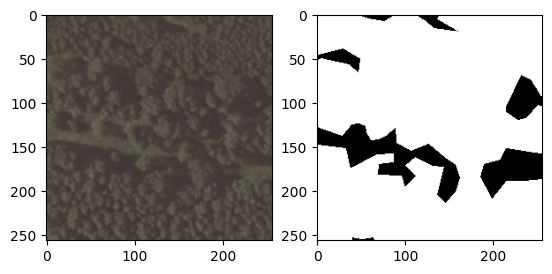

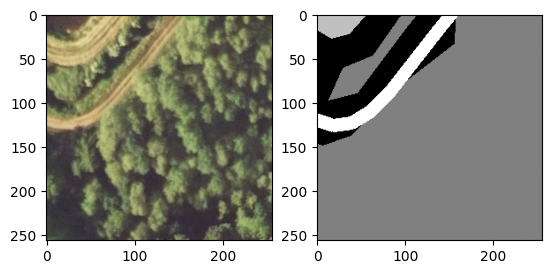

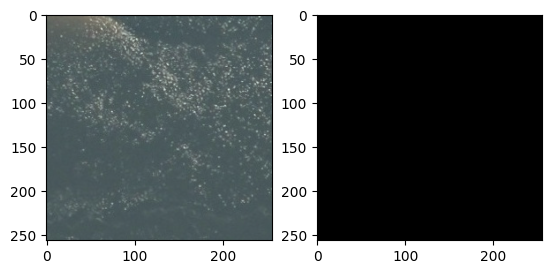

In [160]:
# Load the next batch of batch_size images
x, y = train_img_gen.__next__()

print(x.shape, y.shape)

# Make sure x has 3 layers (RGB)
assert x.shape[3] == 3

# Make sure y has n_classes layers
assert y.shape[3] == n_classes

for i in range(0, 3):
    image = x[i]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.show()

Found 750 images belonging to 1 classes.
Found 750 images belonging to 1 classes.
(16, 256, 256, 3) (16, 256, 256, 5)


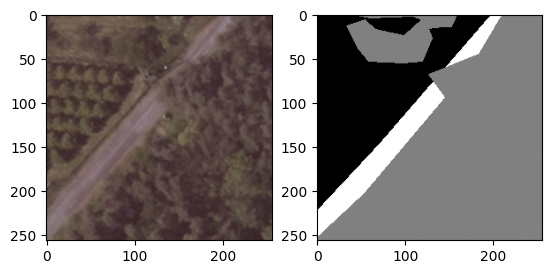

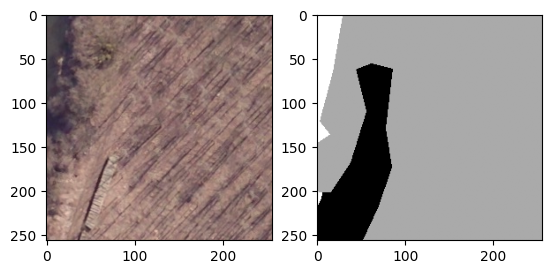

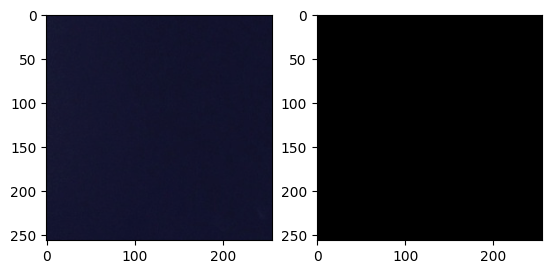

In [161]:
x_val, y_val = val_img_gen.__next__()

print(x_val.shape, y_val.shape)

# Make sure x has 3 layers (RGB)
assert x_val.shape[3] == 3

# Make sure y has n_classes layers
assert y_val.shape[3] == n_classes

for i in range(0, 3):
    image = x_val[i]
    mask = np.argmax(y_val[i], axis=2)
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.show()


### Define the model metrics and load model

In [162]:
num_train_imgs = len([file for file in dir_train_img.iterdir() if file.is_file()])
num_val_images = len([file for file in dir_val_img.iterdir() if file.is_file()])

steps_per_epoch = num_train_imgs // batch_size
val_steps_per_epoch = num_val_images // batch_size

IMG_HEIGHT = x.shape[1]
IMG_WIDTH = x.shape[2]
IMG_CHANNELS = x.shape[3]

EPOCHS = 75

In [163]:
print(num_train_imgs)
print(num_val_images)
print(steps_per_epoch)
print(val_steps_per_epoch)

2250
750
140
46


### Use transfer learning using pretrained encoder in the U-Net

We use ***Intersection over Union (IoU)*** as evaluation metric (see [here](https://towardsdatascience.com/iou-a-better-detection-evaluation-metric-45a511185be1)). is used when calculating Mean average precision (mAP). It is a number from 0 to 1 that specifies the amount of overlap between the predicted and ground truth bounding box:

- an IoU of 0 means that there is no overlap between the boxes
- an IoU of 1 means that the union of the boxes is the same as their overlap indicating that they are completely overlapping

In [164]:
# Define the model
model = sm.Unet(
    BACKBONE,
    encoder_weights="imagenet",
    encoder_freeze=encoder_freeze,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
    classes=len(classes),
    activation="softmax",
)
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import tensorflow as  tf


def custom_iou_score(gt, pr, **kwargs):


    # Cast to float32 using Keras backend
    gt = tf.keras.backend.cast(gt, dtype='float32')
    pr = tf.keras.backend.cast(pr, dtype='float32')
    return sm.metrics.iou_score(gt, pr, **kwargs)


model.compile(
    "Adam",
    loss=sm.losses.categorical_focal_jaccard_loss,
    metrics=[custom_iou_score],
)

# Other losses to try: categorical_focal_dice_loss, cce_jaccard_loss, cce_dice_loss, categorical_focal_loss

print(model.summary())
print(model.input_shape)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 256, 256,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 256, 256,  │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_208  │ (None, 262, 262,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 128, 128,  │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 128, 128,  │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 128, 128,  │          0 │ bn0[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_209  │ (None, 130, 130,  │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 64, 64,    │          0 │ zero_padding2d_2… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 64, 64,    │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 64, 64,    │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 64, 64,    │      4,096 │ stage1_unit1_rel… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 64, 64,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 64, 64,    │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_210  │ (None, 66, 66,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 64, 64,    │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn3    │ (None, 64, 64,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu3  │ (None, 64, 64,    │          0 │ stage1_unit1_bn3

 Total params: 67,295,774 (256.71 MB)

 Trainable params: 9,157,528 (34.93 MB)

 Non-trainable params: 58,138,246 (221.78 MB)

None
(None, 256, 256, 3)


In [165]:
from keras.callbacks import EarlyStopping

stop_early = EarlyStopping(
    monitor="val_iou_score", patience=7, verbose=1, mode='max'
)

In [166]:
# Fit the model
history = model.fit(
    train_img_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    verbose=1,
    validation_data=val_img_gen,
    validation_steps=val_steps_per_epoch,
    callbacks=stop_early,
)

freeze = "freeze" if encoder_freeze else "nofreeze"

file_model = Path(
    dir_models, f"landcover_{BACKBONE}_{EPOCHS}_epochs_batch{batch_size}_{freeze}.hdf5"
)
model.save(file_model)

Epoch 1/75
140/140 ━━━━━━━━━━━━━━━━━━━━ 149s 529ms/step - custom_iou_score: 0.3236 - loss: 0.7143 - val_custom_iou_score: 0.0167 - val_loss: 1.2849
Epoch 2/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 23s 169ms/step - custom_iou_score: 0.5802 - loss: 0.4446

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 36s 255ms/step - custom_iou_score: 0.5528 - loss: 0.4810 - val_custom_iou_score: 0.0745 - val_loss: 1.3421
Epoch 3/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - custom_iou_score: 0.5697 - loss: 0.4617

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 36s 255ms/step - custom_iou_score: 0.5923 - loss: 0.4394 - val_custom_iou_score: 0.0736 - val_loss: 1.3050
Epoch 4/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - custom_iou_score: 0.5615 - loss: 0.4707

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 34s 241ms/step - custom_iou_score: 0.6019 - loss: 0.4339 - val_custom_iou_score: 0.0753 - val_loss: 1.1598
Epoch 5/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - custom_iou_score: 0.6729 - loss: 0.3467

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 34s 244ms/step - custom_iou_score: 0.6057 - loss: 0.4292 - val_custom_iou_score: 0.1102 - val_loss: 1.2383
Epoch 6/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - custom_iou_score: 0.7120 - loss: 0.3026

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 227ms/step - custom_iou_score: 0.5674 - loss: 0.4742 - val_custom_iou_score: 0.3049 - val_loss: 0.8487
Epoch 7/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - custom_iou_score: 0.6834 - loss: 0.3325

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 230ms/step - custom_iou_score: 0.6808 - loss: 0.3444 - val_custom_iou_score: 0.3137 - val_loss: 0.8047
Epoch 8/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - custom_iou_score: 0.6365 - loss: 0.4168

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 230ms/step - custom_iou_score: 0.6114 - loss: 0.4253 - val_custom_iou_score: 0.5140 - val_loss: 0.5400
Epoch 9/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 22s 159ms/step - custom_iou_score: 0.7291 - loss: 0.2943

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 228ms/step - custom_iou_score: 0.6415 - loss: 0.3919 - val_custom_iou_score: 0.5546 - val_loss: 0.4948
Epoch 10/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 22s 160ms/step - custom_iou_score: 0.6228 - loss: 0.4018

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 223ms/step - custom_iou_score: 0.6241 - loss: 0.4112 - val_custom_iou_score: 0.6823 - val_loss: 0.3410
Epoch 11/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - custom_iou_score: 0.7396 - loss: 0.2879

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 223ms/step - custom_iou_score: 0.7146 - loss: 0.3079 - val_custom_iou_score: 0.6794 - val_loss: 0.3455
Epoch 12/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - custom_iou_score: 0.6572 - loss: 0.3667

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 223ms/step - custom_iou_score: 0.7092 - loss: 0.3139 - val_custom_iou_score: 0.6213 - val_loss: 0.4126
Epoch 13/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - custom_iou_score: 0.7189 - loss: 0.2963

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.6746 - loss: 0.3539 - val_custom_iou_score: 0.6068 - val_loss: 0.4366
Epoch 14/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - custom_iou_score: 0.7737 - loss: 0.2436

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.6787 - loss: 0.3510 - val_custom_iou_score: 0.6019 - val_loss: 0.4380
Epoch 15/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - custom_iou_score: 0.7038 - loss: 0.3188

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.6746 - loss: 0.3554 - val_custom_iou_score: 0.6030 - val_loss: 0.4373
Epoch 16/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - custom_iou_score: 0.6494 - loss: 0.3715

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 224ms/step - custom_iou_score: 0.6720 - loss: 0.3577 - val_custom_iou_score: 0.6540 - val_loss: 0.3748
Epoch 17/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - custom_iou_score: 0.7227 - loss: 0.3004

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 30s 218ms/step - custom_iou_score: 0.6795 - loss: 0.3474 - val_custom_iou_score: 0.6463 - val_loss: 0.3880
Epoch 18/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - custom_iou_score: 0.7994 - loss: 0.2131

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.6963 - loss: 0.3323 - val_custom_iou_score: 0.2393 - val_loss: 1.0150
Epoch 19/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 22s 162ms/step - custom_iou_score: 0.7748 - loss: 0.2450

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 227ms/step - custom_iou_score: 0.3304 - loss: 0.7490 - val_custom_iou_score: 0.1116 - val_loss: 0.9392
Epoch 20/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - custom_iou_score: 0.1169 - loss: 0.9198

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.2843 - loss: 0.7542 - val_custom_iou_score: 0.5194 - val_loss: 0.5173
Epoch 21/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - custom_iou_score: 0.7028 - loss: 0.3309

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.6682 - loss: 0.3663 - val_custom_iou_score: 0.6445 - val_loss: 0.3822
Epoch 22/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 22s 162ms/step - custom_iou_score: 0.7810 - loss: 0.2372

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.6691 - loss: 0.3644 - val_custom_iou_score: 0.6516 - val_loss: 0.3786
Epoch 23/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - custom_iou_score: 0.7443 - loss: 0.2804

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 227ms/step - custom_iou_score: 0.5546 - loss: 0.5154 - val_custom_iou_score: 0.6273 - val_loss: 0.4160
Epoch 24/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - custom_iou_score: 0.7510 - loss: 0.2656

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.6644 - loss: 0.3656 - val_custom_iou_score: 0.6551 - val_loss: 0.3758
Epoch 25/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - custom_iou_score: 0.7635 - loss: 0.2568

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.6932 - loss: 0.3363 - val_custom_iou_score: 0.6579 - val_loss: 0.3725
Epoch 26/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - custom_iou_score: 0.7801 - loss: 0.2380

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.7093 - loss: 0.3169 - val_custom_iou_score: 0.6611 - val_loss: 0.3765
Epoch 27/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 22s 160ms/step - custom_iou_score: 0.8018 - loss: 0.2136

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 228ms/step - custom_iou_score: 0.6922 - loss: 0.3360 - val_custom_iou_score: 0.6333 - val_loss: 0.4043
Epoch 28/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 22s 163ms/step - custom_iou_score: 0.7651 - loss: 0.2551

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 227ms/step - custom_iou_score: 0.6843 - loss: 0.3431 - val_custom_iou_score: 0.6022 - val_loss: 0.4468
Epoch 29/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - custom_iou_score: 0.7908 - loss: 0.2339

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 224ms/step - custom_iou_score: 0.6636 - loss: 0.3690 - val_custom_iou_score: 0.6536 - val_loss: 0.3826
Epoch 30/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 22s 160ms/step - custom_iou_score: 0.7220 - loss: 0.2964

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 221ms/step - custom_iou_score: 0.6995 - loss: 0.3279 - val_custom_iou_score: 0.6831 - val_loss: 0.3488
Epoch 31/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - custom_iou_score: 0.7892 - loss: 0.2291

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.7446 - loss: 0.2788 - val_custom_iou_score: 0.6989 - val_loss: 0.3315
Epoch 32/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - custom_iou_score: 0.7435 - loss: 0.2690

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.7296 - loss: 0.2926 - val_custom_iou_score: 0.7203 - val_loss: 0.3046
Epoch 33/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - custom_iou_score: 0.7516 - loss: 0.2641

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 227ms/step - custom_iou_score: 0.7145 - loss: 0.3126 - val_custom_iou_score: 0.6337 - val_loss: 0.4083
Epoch 34/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - custom_iou_score: 0.5861 - loss: 0.4442

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 228ms/step - custom_iou_score: 0.6155 - loss: 0.4402 - val_custom_iou_score: 0.6141 - val_loss: 0.4331
Epoch 35/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - custom_iou_score: 0.6627 - loss: 0.3451

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 229ms/step - custom_iou_score: 0.6750 - loss: 0.3574 - val_custom_iou_score: 0.6224 - val_loss: 0.4231
Epoch 36/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - custom_iou_score: 0.7885 - loss: 0.2309

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 228ms/step - custom_iou_score: 0.6770 - loss: 0.3562 - val_custom_iou_score: 0.6801 - val_loss: 0.3520
Epoch 37/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 22s 160ms/step - custom_iou_score: 0.6628 - loss: 0.3675

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.7195 - loss: 0.3082 - val_custom_iou_score: 0.6482 - val_loss: 0.3913
Epoch 38/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - custom_iou_score: 0.8145 - loss: 0.2062

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 227ms/step - custom_iou_score: 0.7080 - loss: 0.3220 - val_custom_iou_score: 0.6448 - val_loss: 0.3979
Epoch 39/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - custom_iou_score: 0.7111 - loss: 0.3086

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 229ms/step - custom_iou_score: 0.7106 - loss: 0.3171 - val_custom_iou_score: 0.6517 - val_loss: 0.3867
Epoch 40/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 22s 160ms/step - custom_iou_score: 0.8148 - loss: 0.2014

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 227ms/step - custom_iou_score: 0.6911 - loss: 0.3402 - val_custom_iou_score: 0.7436 - val_loss: 0.2773
Epoch 41/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - custom_iou_score: 0.7197 - loss: 0.2956

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 227ms/step - custom_iou_score: 0.7748 - loss: 0.2430 - val_custom_iou_score: 0.6277 - val_loss: 0.4201
Epoch 42/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - custom_iou_score: 0.7499 - loss: 0.2693

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 229ms/step - custom_iou_score: 0.7035 - loss: 0.3264 - val_custom_iou_score: 0.6273 - val_loss: 0.4161
Epoch 43/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - custom_iou_score: 0.7514 - loss: 0.2647

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 228ms/step - custom_iou_score: 0.6828 - loss: 0.3496 - val_custom_iou_score: 0.6223 - val_loss: 0.4266
Epoch 44/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - custom_iou_score: 0.6981 - loss: 0.3182

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.6905 - loss: 0.3421 - val_custom_iou_score: 0.6990 - val_loss: 0.3344
Epoch 45/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - custom_iou_score: 0.7885 - loss: 0.2247

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 227ms/step - custom_iou_score: 0.7363 - loss: 0.2886 - val_custom_iou_score: 0.6501 - val_loss: 0.3903
Epoch 46/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 22s 159ms/step - custom_iou_score: 0.8091 - loss: 0.2068

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.7059 - loss: 0.3244 - val_custom_iou_score: 0.6215 - val_loss: 0.4275
Epoch 47/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - custom_iou_score: 0.7507 - loss: 0.2680

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 227ms/step - custom_iou_score: 0.7038 - loss: 0.3296 - val_custom_iou_score: 0.6760 - val_loss: 0.3573
Epoch 48/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 22s 159ms/step - custom_iou_score: 0.6464 - loss: 0.3678

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 227ms/step - custom_iou_score: 0.7509 - loss: 0.2705 - val_custom_iou_score: 0.7318 - val_loss: 0.2906
Epoch 49/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 22s 160ms/step - custom_iou_score: 0.8140 - loss: 0.2049

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.7817 - loss: 0.2355 - val_custom_iou_score: 0.7334 - val_loss: 0.2886
Epoch 50/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - custom_iou_score: 0.7518 - loss: 0.2662

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 229ms/step - custom_iou_score: 0.7895 - loss: 0.2272 - val_custom_iou_score: 0.6148 - val_loss: 0.4332
Epoch 51/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - custom_iou_score: 0.8543 - loss: 0.1532

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 230ms/step - custom_iou_score: 0.6905 - loss: 0.3426 - val_custom_iou_score: 0.6254 - val_loss: 0.4195
Epoch 52/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - custom_iou_score: 0.7183 - loss: 0.2978

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 228ms/step - custom_iou_score: 0.7049 - loss: 0.3262 - val_custom_iou_score: 0.6044 - val_loss: 0.4488
Epoch 53/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - custom_iou_score: 0.8081 - loss: 0.2044

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 228ms/step - custom_iou_score: 0.6815 - loss: 0.3509 - val_custom_iou_score: 0.6400 - val_loss: 0.4024
Epoch 54/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - custom_iou_score: 0.8470 - loss: 0.1612

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 228ms/step - custom_iou_score: 0.7008 - loss: 0.3268 - val_custom_iou_score: 0.6164 - val_loss: 0.4326
Epoch 55/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - custom_iou_score: 0.8051 - loss: 0.2083

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 227ms/step - custom_iou_score: 0.6953 - loss: 0.3360 - val_custom_iou_score: 0.6285 - val_loss: 0.4165
Epoch 56/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 22s 159ms/step - custom_iou_score: 0.7961 - loss: 0.2220

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 228ms/step - custom_iou_score: 0.7154 - loss: 0.3135 - val_custom_iou_score: 0.6273 - val_loss: 0.4240
Epoch 57/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - custom_iou_score: 0.8107 - loss: 0.2077

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 227ms/step - custom_iou_score: 0.7203 - loss: 0.3094 - val_custom_iou_score: 0.7449 - val_loss: 0.2758
Epoch 58/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - custom_iou_score: 0.7803 - loss: 0.2408

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 228ms/step - custom_iou_score: 0.7947 - loss: 0.2215 - val_custom_iou_score: 0.6446 - val_loss: 0.4031
Epoch 59/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - custom_iou_score: 0.8680 - loss: 0.1408

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 227ms/step - custom_iou_score: 0.7073 - loss: 0.3230 - val_custom_iou_score: 0.6156 - val_loss: 0.4289
Epoch 60/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - custom_iou_score: 0.8253 - loss: 0.1907

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 227ms/step - custom_iou_score: 0.7205 - loss: 0.3082 - val_custom_iou_score: 0.6386 - val_loss: 0.4048
Epoch 61/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - custom_iou_score: 0.8212 - loss: 0.2002

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 227ms/step - custom_iou_score: 0.7067 - loss: 0.3233 - val_custom_iou_score: 0.6358 - val_loss: 0.4086
Epoch 62/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 22s 159ms/step - custom_iou_score: 0.8214 - loss: 0.1932

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.7141 - loss: 0.3156 - val_custom_iou_score: 0.6238 - val_loss: 0.4238
Epoch 63/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - custom_iou_score: 0.8323 - loss: 0.1826

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 227ms/step - custom_iou_score: 0.7237 - loss: 0.3046 - val_custom_iou_score: 0.6284 - val_loss: 0.4148
Epoch 64/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - custom_iou_score: 0.8247 - loss: 0.1907

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.7274 - loss: 0.3020 - val_custom_iou_score: 0.6445 - val_loss: 0.3998
Epoch 65/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 22s 160ms/step - custom_iou_score: 0.7938 - loss: 0.2242

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - custom_iou_score: 0.7091 - loss: 0.3226 - val_custom_iou_score: 0.6581 - val_loss: 0.3819
Epoch 66/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - custom_iou_score: 0.8357 - loss: 0.1768

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 224ms/step - custom_iou_score: 0.7428 - loss: 0.2818 - val_custom_iou_score: 0.6412 - val_loss: 0.4013
Epoch 67/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - custom_iou_score: 0.7850 - loss: 0.2351

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 224ms/step - custom_iou_score: 0.7382 - loss: 0.2887 - val_custom_iou_score: 0.6422 - val_loss: 0.3997
Epoch 68/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 22s 159ms/step - custom_iou_score: 0.8260 - loss: 0.1888

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 224ms/step - custom_iou_score: 0.7232 - loss: 0.3064 - val_custom_iou_score: 0.7452 - val_loss: 0.2764
Epoch 69/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - custom_iou_score: 0.7383 - loss: 0.2731

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 228ms/step - custom_iou_score: 0.8025 - loss: 0.2121 - val_custom_iou_score: 0.6325 - val_loss: 0.4135
Epoch 70/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - custom_iou_score: 0.8628 - loss: 0.1487

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.7403 - loss: 0.2874 - val_custom_iou_score: 0.6309 - val_loss: 0.4118
Epoch 71/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - custom_iou_score: 0.8398 - loss: 0.1700

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.7336 - loss: 0.2939 - val_custom_iou_score: 0.7556 - val_loss: 0.2656
Epoch 72/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - custom_iou_score: 0.8399 - loss: 0.1771

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 228ms/step - custom_iou_score: 0.8124 - loss: 0.2018 - val_custom_iou_score: 0.6239 - val_loss: 0.4221
Epoch 73/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - custom_iou_score: 0.8320 - loss: 0.1789

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 227ms/step - custom_iou_score: 0.7361 - loss: 0.2916 - val_custom_iou_score: 0.6773 - val_loss: 0.3622
Epoch 74/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - custom_iou_score: 0.8831 - loss: 0.1289

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.7339 - loss: 0.2940 - val_custom_iou_score: 0.6161 - val_loss: 0.4334
Epoch 75/75
  1/140 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - custom_iou_score: 0.7797 - loss: 0.2365

/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - custom_iou_score: 0.7010 - loss: 0.3312 - val_custom_iou_score: 0.6624 - val_loss: 0.3766


/project/cpu/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_score` which is not available. Available metrics are: custom_iou_score,loss,val_custom_iou_score,val_loss
  current = self.get_monitor_value(logs)


### Plot training and validation IoU and loss at each epoch

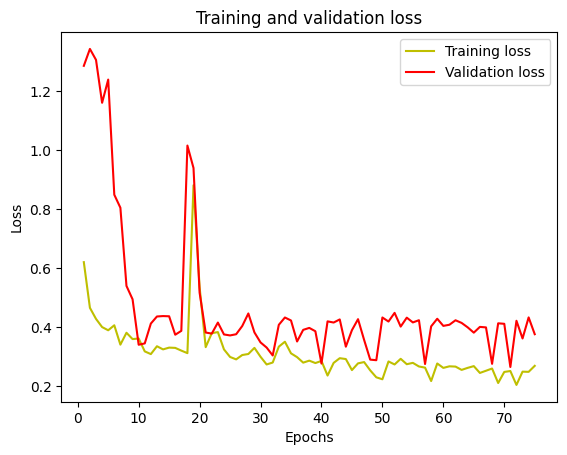

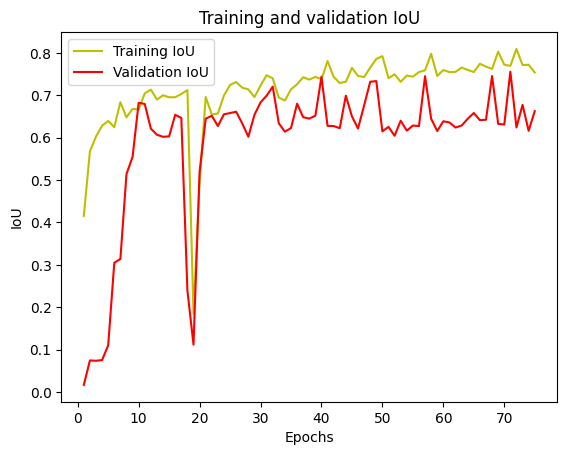

In [167]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "y", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["custom_iou_score"]
val_acc = history.history["val_custom_iou_score"]

plt.plot(epochs, acc, "y", label="Training IoU")
plt.plot(epochs, val_acc, "r", label="Validation IoU")
plt.title("Training and validation IoU")
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.legend()
plt.show()

In [168]:
print(model.input_shape, model.output_shape)


(None, 256, 256, 3) (None, 256, 256, 5)


### Evaulate model on test data

In [169]:

model = load_model(file_model, compile=False)
model.save(file_model)
# Test generator using validation data.
test_image_batch, test_mask_batch = val_img_gen.__next__()

# Convert categorical to integer for visualization and IoU calculation
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3)
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Mean IoU = 0.7381773


## Calculation

- Accuracy is typically used for classification tasks, where the goal is to predict discrete classes. In semantic segmentation, accuracy measures the percentage of pixels that are correctly classified.

- R-squared (R2) is commonly used in regression problems to measure the goodness of fit. It's less relevant in semantic segmentation, which is primarily a classification task.
- Mean Squared Error (MSE) is a regression metric that quantifies the average squared difference between predicted and true values. In semantic segmentation, it can be applied to the pixel-wise probabilities or class labels. However, it might not be the most informative metric for this task.
- Loss is the function used to optimize the model during training. In semantic segmentation, various loss functions can be employed, such as categorical cross-entropy or Dice loss. The loss value reflects the model's overall performance during training.

In [170]:
# Access the loss value from the training history
loss = history.history['loss'][-1]  # Get the last loss value
print("Loss:", loss)

from sklearn.metrics import mean_squared_error

# Flatten predictions and ground truth
y_true_flat = test_mask_batch_argmax.flatten()  # Or use original probabilities
y_pred_flat = test_pred_batch_argmax.flatten()  # Or use original probabilities

# Calculate MSE
mse = mean_squared_error(y_true_flat, y_pred_flat)
print("Mean Squared Error:", mse)


from sklearn.metrics import accuracy_score

# Flatten predictions and ground truth
y_true_flat = test_mask_batch_argmax.flatten()
y_pred_flat = test_pred_batch_argmax.flatten()

# Calculate accuracy
accuracy = accuracy_score(y_true_flat, y_pred_flat)
print("Accuracy:", accuracy)


# less Relevant
from sklearn.metrics import r2_score

# Assuming you have continuous predictions (e.g., probabilities)
y_true_flat = test_mask_batch.flatten()  # Use original probabilities
y_pred_flat = test_pred_batch.flatten()  # Use original probabilities

# Calculate R-squared
r2 = r2_score(y_true_flat, y_pred_flat)
print("R-squared:", r2)

Loss: 0.2695704996585846
Mean Squared Error: 0.39960289001464844
Accuracy: 0.9392318725585938
R-squared: 0.8597323520265908


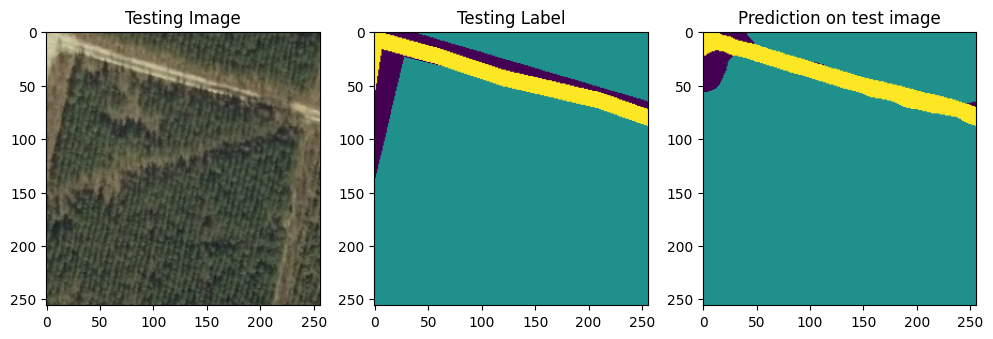

In [172]:
# View a few images, masks and corresponding predictions.
img_num = random.randint(0, test_image_batch.shape[0] - 1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title("Testing Image")
plt.imshow(test_image_batch[img_num])
plt.subplot(232)
plt.title("Testing Label")
plt.imshow(test_mask_batch_argmax[img_num])
plt.subplot(233)
plt.title("Prediction on test image")
plt.imshow(test_pred_batch_argmax[img_num])
plt.show()